In [8]:
import pandas as pd
import numpy as np

In [9]:
raw_mail_data = pd.read_csv("C:\Dhanesh\ML\ML_DBMS\spam_ham_dataset.csv\spam_ham_dataset.csv")
print(raw_mail_data.shape)
raw_mail_data.head()

(5171, 4)


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [10]:
# process

# 1. Data Cleaning = removing NaN values
# 2. EDA
# 3. Text Preproccesing
# 4. Model Building
# 5. Model Evaluation
# 6. Improvement

DATA CLEANING

In [11]:
raw_mail_data.info()
mail_data = raw_mail_data.drop(columns=['Unnamed: 0','label'])
mail_data.rename(columns={'label_num': 'target'},inplace=True)
print(mail_data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
                                                   text  target
3607  Subject: tenaska iv 12 / 00\r\ndarren :\r\nple...       0
599   Subject: fw : father ' s letter\r\n- - - - - o...       0
2085  Subject: hallo mein unbekannter\r\nhallo\r\nic...       1
4657  Subject: meter 980070 lonestar / hpl rusk for ...       0
280   Subject: nomination 2 / 3 / 2000\r\nthis is to...       0


In [12]:
# missing values 
mail_data.isnull().sum()

# duplicated values
mail_data.duplicated().sum()
mail_data.drop_duplicates(keep='first')

mail_data.shape

(5171, 2)

EXPLORATORY DATA ANALYSIS

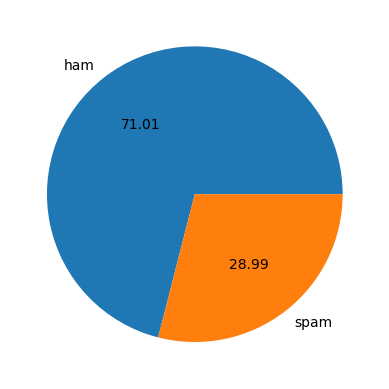

In [13]:
import matplotlib.pyplot as plt

plt.pie(mail_data['target'].value_counts(), labels=['ham','spam'], autopct = "%0.2f")
plt.show()

# data is imbalanced

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Dhanesh
[nltk_data]     Sawant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
mail_data['num_characters'] = mail_data['text'].apply(len)
mail_data['num_words'] = mail_data['text'].apply(lambda x:len(nltk.word_tokenize(x))) # returns a list & stores in column
mail_data['num_sentences'] = mail_data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
print(mail_data.sample(5))



                                                   text  target  \
2488  Subject: re : base gas roll\r\nthanks ,\r\ngg\...       0   
3655  Subject: weekend activity dated : june 2 thru ...       0   
4201  Subject: barely of age and ready for your comp...       1   
182                                       Subject: \r\n       1   
2933  Subject: pharma\r\nstop wasting money on presc...       1   

      num_characters  num_words  num_sentences  
2488             324         73              2  
3655            1272        298             20  
4201              77         15              1  
182               11          2              1  
2933             438         97             13  


In [16]:
mail_data[['num_characters','num_words','num_sentences']].describe()  # [[ as we pass a list

# HAM
mail_data[mail_data['target']==0][['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,3672.000000,3672.000000,3672.000000
mean,977.008170,226.239107,11.440904
std,1382.827493,332.179661,24.892442
min,18.000000,3.000000,1.000000
25%,231.750000,51.000000,3.000000
50%,530.000000,124.000000,6.000000
75%,1227.250000,294.000000,13.000000
max,32258.000000,8863.000000,1204.000000


In [17]:
# SPAM
mail_data[mail_data['target']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1499.000000,1499.000000,1499.000000
mean,1223.256171,236.387592,17.237492
std,1825.986210,346.821249,32.796043
min,11.000000,2.000000,1.000000
25%,283.000000,55.000000,4.000000
50%,576.000000,116.000000,9.000000
75%,1253.500000,244.000000,18.500000
max,22073.000000,3963.000000,693.000000


<Axes: xlabel='num_characters', ylabel='Count'>

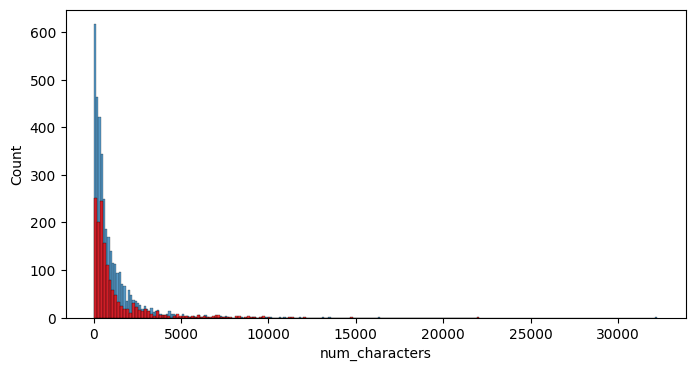

In [18]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(mail_data[mail_data['target']==0]['num_characters']) # ham
sns.histplot(mail_data[mail_data['target']==1]['num_characters'],color='red')  # spam

# ham has more length than ham 

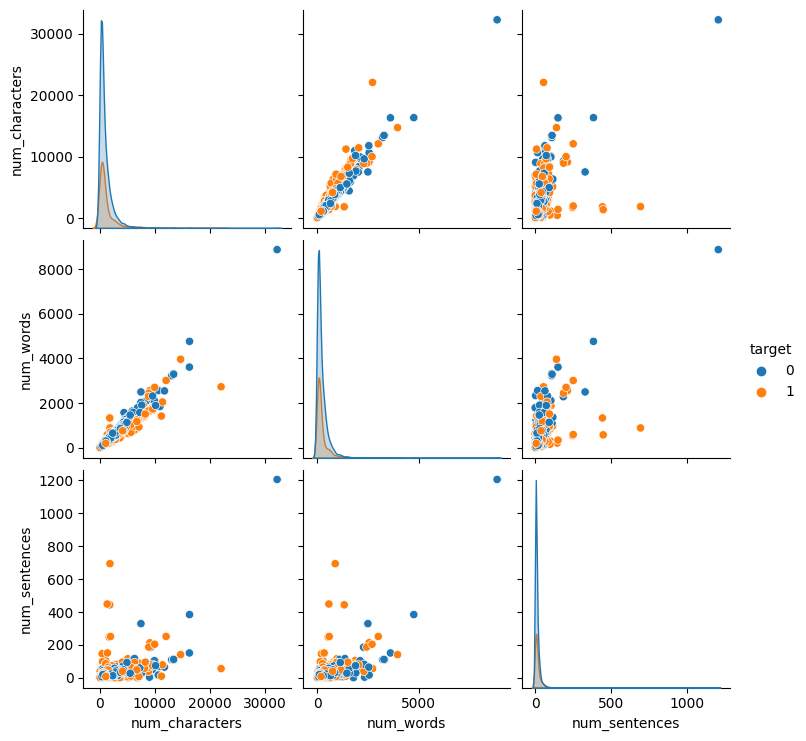

In [19]:
sns.pairplot(mail_data,hue='target')

# outliers in data

C:\Users\Dhanesh Sawant\AppData\Local\Temp\ipykernel_1424\16089883.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mail_data.corr(),annot=True)


<Axes: >

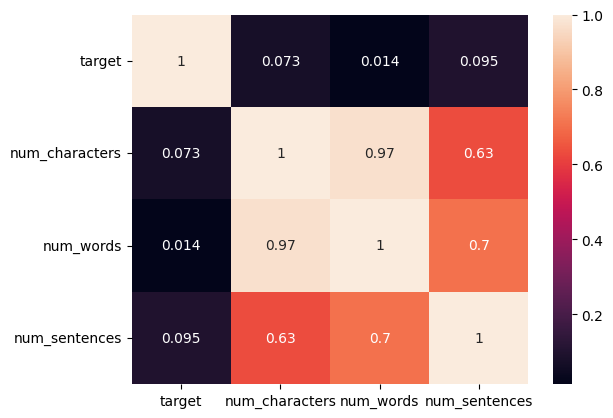

In [20]:
sns.heatmap(mail_data.corr(),annot=True)

# strong correlation btw num_words and num_characters

DATA PREPROCESSING :   

1. LOWER CASE
2. TOKENISATION
3. REMOVING SPECIAL CHARACTERS
4. REMOVING STOP WORDS & PUNCTUATIONS
5. STEMMING

In [21]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer


stopwords.words('english')
string.punctuation
PorterStemmer().stem('dancing')

'danc'

In [22]:
def transform_text(text):
    
    text = text.lower() # lower case
    text = nltk.word_tokenize(text) # tokenisation
    
    y = [] # removing special characters & punctuations
    for i in text:
        if i.isalnum():
            y.append(i)  
            
    text = y[:]  # we cant directly copy lists 
    y.clear()      
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)    
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(PorterStemmer().stem(i))
    
    return " ".join(y)    

In [23]:
mail_data['transformed_data'] = mail_data['text'].apply(transform_text)
print(mail_data.sample(5))

                                                   text  target  \
2351  Subject: tenaska iv march 2001\r\nwe have the ...       0   
3669  Subject: important auction info\r\nr 3 move\r\...       1   
3626  Subject: re : covenants - project miracle\r\no...       0   
921   Subject: new stack manager\r\nthere is a new v...       0   
1389  Subject: re : i / c variance for deal 72893\r\...       0   

      num_characters  num_words  num_sentences  \
2351             433         95              7   
3669             124         23              1   
3626            1635        312              9   
921             1456        269             12   
1389            1160        312             20   

                                       transformed_data  
2351  subject tenaska iv march 2001 actual txu tenas...  
3669  subject import auction info r 3 move market re...  
3626  subject coven project miracl one import item m...  
921   subject new stack manag new version stack mana...  
1389  

In [44]:
spam_corpus = []

for msg in mail_data[mail_data['target']==1]['transformed_data'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        
len(spam_corpus)

from collections import Counter
Counter(spam_corpus).most_common(30)


[('subject', 1659),
 ('3', 1239),
 ('com', 992),
 ('http', 984),
 ('compani', 918),
 ('2', 858),
 ('price', 732),
 ('1', 720),
 ('0', 698),
 ('e', 638),
 ('www', 587),
 ('00', 585),
 ('inform', 557),
 ('get', 555),
 ('font', 515),
 ('email', 513),
 ('5', 510),
 ('pleas', 506),
 ('td', 504),
 ('secur', 499),
 ('statement', 497),
 ('4', 494),
 ('invest', 473),
 ('us', 469),
 ('stock', 467),
 ('product', 463),
 ('7', 457),
 ('time', 449),
 ('new', 432),
 ('may', 421)]

MODEL BUILDING

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(mail_data['transformed_data']).toarray()
X.shape

y = mail_data['target'].values
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=2)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score


In [36]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [38]:
gnb.fit(X_train,Y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(Y_test,y_pred1))
print(confusion_matrix(Y_test,y_pred1))
print(precision_score(Y_test,y_pred1))

0.9516908212560387
[[717  29]
 [ 21 268]]
0.9023569023569024


In [41]:
mnb.fit(X_train,Y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(Y_test,y_pred2))
print(confusion_matrix(Y_test,y_pred2))
print(precision_score(Y_test,y_pred2))

0.9227053140096618
[[746   0]
 [ 80 209]]
1.0


In [42]:
bnb.fit(X_train,Y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(Y_test,y_pred3))
print(confusion_matrix(Y_test,y_pred3))
print(precision_score(Y_test,y_pred3))

0.851207729468599
[[725  21]
 [133 156]]
0.8813559322033898


In [46]:
# therefore we choose tfidf --> mnb

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [47]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')

In [48]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc,
}

In [49]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [51]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,Y_train,X_test,Y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9884057971014493
Precision -  0.9601328903654485
For  KN
Accuracy -  0.9671497584541063
Precision -  0.9811320754716981
For  NB
Accuracy -  0.9227053140096618
Precision -  1.0
For  DT
Accuracy -  0.8628019323671497
Precision -  0.8
For  LR
Accuracy -  0.966183574879227
Precision -  0.89937106918239


In [52]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
2,NB,0.922705,1.000000
1,KN,0.967150,0.981132
0,SVC,0.988406,0.960133
4,LR,0.966184,0.899371
3,DT,0.862802,0.800000


In [57]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1


,Algorithm,variable,value
0,NB,Accuracy,0.922705
1,KN,Accuracy,0.967150
2,SVC,Accuracy,0.988406
3,LR,Accuracy,0.966184
4,DT,Accuracy,0.862802
5,NB,Precision,1.000000
6,KN,Precision,0.981132
7,SVC,Precision,0.960133
8,LR,Precision,0.899371
9,DT,Precision,0.800000


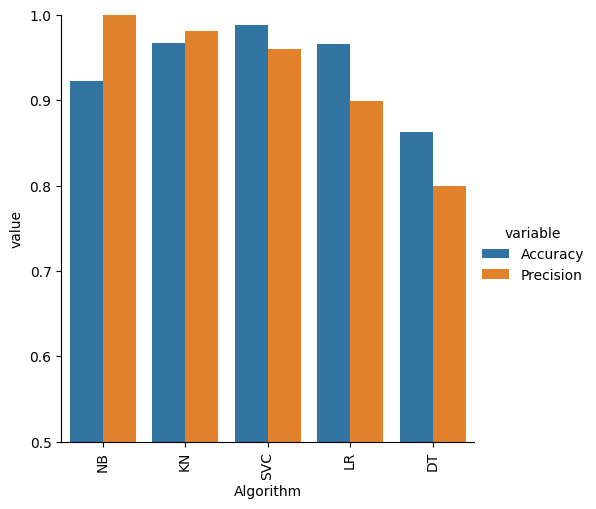

In [58]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))